In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
tf.__version__

'2.3.0'

### 1)Linear Classifier for CIFAR10

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train: ', x_train.shape)
print('y_test: ',y_test.shape)
print('y_test[0]',y_test[0])

K = len(np.unique(y_train)) # Number of Classes
print('Number of classes: ',K)

x_train:  (50000, 32, 32, 3)
y_test:  (10000, 1)
y_test[0] [3]
Number of classes:  10


In [4]:
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = 3072 # CIFAR10, 32x32x3=3072
# Din = 784 # MINIST

# Normalize pixel values: numpy works in one datatype(weights,features):float, faster training,
x_train, x_test = x_train / 255.0, x_test / 255.0


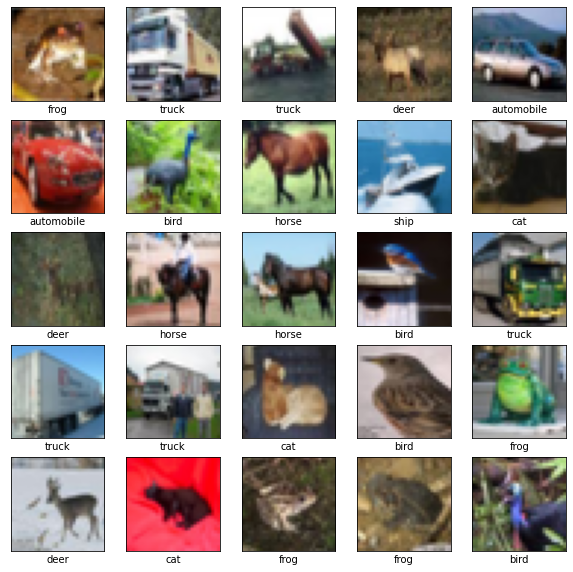

In [5]:
#verify data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [6]:
#centering the data and making range similar in order to get stable gradients
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

#re-classify the y(label) sets as categorical: onehot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

#resize x set into a collection of rows, each row is an image
x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

y_train: (50000, 10)
y_test: (10000, 10)
x_train: (50000, 3072)
x_test: (10000, 3072)


In [7]:
#initialize the Weight matrix and bias 
std=1e-5
w1 = std*np.random.randn(Din, K)
b1 = np.zeros(K)
print("w1:", w1.shape)
print("b1:", b1.shape)

w1: (3072, 10)
b1: (10,)


In [8]:
#parameters
batch_size = Ntr    #set batchsize to entire trainingset size
iterations = 300
lr = 0.015         #learning rate
lr_decay= 0.9999   #learning rate decay
reg = 1e-7         #regularization parameter
loss_history = []
train_acc_history = []
val_acc_history = []

#fix seed for random number generator
seed = 0
rng = np.random.default_rng(seed=seed)

In [9]:
def accuracy(y_pred,y):
    predclass = np.argmax(y_pred,axis=1)
    realclass = np.argmax(y,axis=1)
    return ( np.sum(predclass==realclass)/realclass.size )

In [10]:
def reg_MSloss(y_pred,y,batchsize,reg,w1):
    return (1./batchsize)* np.square(y_pred-y).sum()  + reg*np.sum( [np.sum(w*w)for w in w1] )


In [11]:
def runlinearmodel(batchsize=batch_size,iterations=iterations,lr=lr,lr_decay=lr_decay,reg=reg):
    t0 = time.time()
    std=1e-5
    w1 = std*np.random.randn(Din, K)
    b1 = np.zeros(K)

    loss_history = []
    test_losshistory = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    for t in range(iterations+1):
        batch_indices = np.random.choice(Ntr,batch_size)
        rng.shuffle(batch_indices)
        x = x_train[batch_indices]
        y = y_train[batch_indices]

        # Forward pass
        y_pred = x.dot(w1) + b1
        testy = x_test.dot(w1) + b1

        train_loss = reg_MSloss(y_pred,y,batch_size,reg,[w1]) #regularized mean square loss
        test_loss = reg_MSloss(testy,y_test,10000,reg,[w1])
        loss_history.append(train_loss)
        test_losshistory.append(test_loss)

        train_acc= accuracy(y_pred,y)
        train_acc_history.append(train_acc)

        val_acc=accuracy(testy,y_test)
        val_acc_history.append(val_acc)
        

        if t%10 == 0:
            print('epoch %d/%d: MSloss= %f-- ,test loss= %f--,train accracy= %f--, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,val_acc))
        
        dy_pred = (1./batch_size)*2.0*(y_pred-y)
        dw1 = x.T.dot(dy_pred) + reg*w1
        db1 = dy_pred.sum(axis=0)

        # Backward pass
        w1 -= lr*dw1
        b1 -= lr*db1
        lr *= lr_decay

    t1 = time.time()
    print('time taken = ',(t1-t0))

    return w1,loss_history,test_losshistory,train_acc_history,val_acc_history


In [12]:

w1,loss_history1,test_losshistory1,train_acc_history1,val_acc_history1 = runlinearmodel()

epoch 0/300: MSloss= 0.999994-- ,test loss= 0.999990--,train accracy= 0.096000--, test accracy= 0.093200
epoch 10/300: MSloss= 0.872383-- ,test loss= 0.872677--,train accracy= 0.357220--, test accracy= 0.352500
epoch 20/300: MSloss= 0.838139-- ,test loss= 0.838464--,train accracy= 0.375640--, test accracy= 0.374300
epoch 30/300: MSloss= 0.820456-- ,test loss= 0.820368--,train accracy= 0.382780--, test accracy= 0.384500
epoch 40/300: MSloss= 0.809320-- ,test loss= 0.809835--,train accracy= 0.391880--, test accracy= 0.386000
epoch 50/300: MSloss= 0.803502-- ,test loss= 0.803737--,train accracy= 0.391680--, test accracy= 0.387900
epoch 60/300: MSloss= 0.799264-- ,test loss= 0.799805--,train accracy= 0.401540--, test accracy= 0.393700
epoch 70/300: MSloss= 0.796552-- ,test loss= 0.797370--,train accracy= 0.400840--, test accracy= 0.394800
epoch 80/300: MSloss= 0.793251-- ,test loss= 0.795630--,train accracy= 0.406740--, test accracy= 0.396000
epoch 90/300: MSloss= 0.792263-- ,test loss= 0.

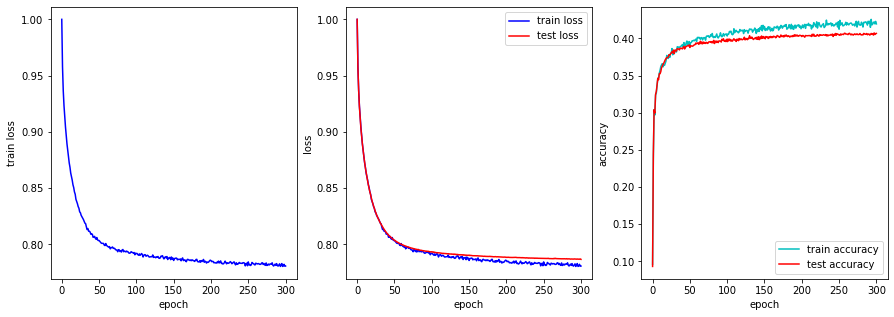

In [23]:
#display Train loss,train accuracy
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(loss_history1,'b')
ax[0].set_xlabel('epoch') 
ax[0].set_ylabel('train loss') 

ax[1].plot(loss_history1,'b')
ax[1].plot(test_losshistory1,'r')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')  
ax[1].legend(['train loss','test loss'])

ax[2].plot(train_acc_history1,'c')
ax[2].plot(val_acc_history1,'r')
ax[2].set_xlabel('epoch')
ax[2].set_ylabel('accuracy')  
ax[2].legend(['train accuracy','test accuracy']);


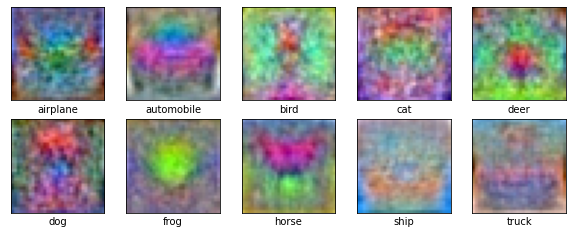

In [14]:
 # W is effectively 10 separate linear classifiers: one classifier per column of W 
 # Displaying w as images
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    w = w1[:,i]
    wnorm = (w-min(w))/max(w) #+ mean_image.reshape(3072)
    wnorm = wnorm/max(wnorm)
    plt.imshow(wnorm.reshape((32,32,3)), cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays need the extra index
    plt.xlabel(class_names[i])
plt.show()


In [15]:
print(w1.shape)
w1_test = w1[:,1]
print(w1_test.shape)
#print(w1_test[:20])

(3072, 10)
(3072,)


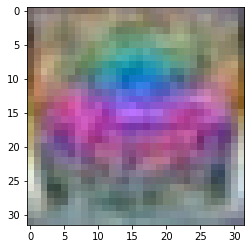

In [16]:
w1norm = (w1_test-min(w1_test))/max(w1_test)
w1norm = w1norm/max(w1norm)
#print(w1norm[:20])
plt.figure(figsize=(4,4))
plt.imshow(w1norm.reshape((32,32,3)) )
plt.show()

### 2) 2 Layer Fully connected NN
####   Hidden Layer activation - sigmoid

In [17]:
def run2LNN(batchsize=batch_size,iterations=iterations,lr=lr,lr_decay=lr_decay,reg=reg):
    t0 = time.time()
    std=1e-5
    H = 200
    w1 = std*np.random.randn(Din, H)
    b1 = np.zeros(H)
    w2 = std*np.random.randn(H,K)
    b2 = np.zeros(K)

    loss_history = []
    test_losshistory = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    for t in range(iterations+1):
        batch_indices = np.random.choice(Ntr,batch_size)
        rng.shuffle(batch_indices)
        x = x_train[batch_indices]*255
        y = y_train[batch_indices]

        # Forward pass
        z = x.dot(w1) + b1
        a = 1./(1 + np.exp(-z)) #sigmoid activation
        y_pred = a.dot(w2) + b2

        testz = 255*x_test.dot(w1) + b1
        testa = 1./(1 + np.exp(-testz)) #sigmoid activation
        testy = testa.dot(w2) + b2

        train_loss = reg_MSloss(y_pred,y,batch_size,reg,[w1,w2]) #regularized mean square loss
        test_loss = reg_MSloss(testy,y_test,10000,reg,[w1,w2])
        loss_history.append(train_loss)
        test_losshistory.append(test_loss)

        train_acc= accuracy(y_pred,y)
        train_acc_history.append(train_acc)

        val_acc=accuracy(testy,y_test)
        val_acc_history.append(val_acc)
        

        if t%10 == 0:
            print('epoch %d/%d: MSloss= %f-- ,test loss= %f--,train accracy= %f--, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,val_acc))
        
        dy_pred = (1./batch_size)*2.0*(y_pred-y)
        dw2 = a.T.dot(dy_pred) + reg*w2
        db2 = dy_pred.sum(axis=0)
        
        da = dy_pred.dot(w2.T)
        dz = a*(1-a)*da
        dw1 = x.T.dot(dz) + reg*w1
        db1 = dz.sum(axis=0)


        # Backward pass
        w1 -= lr*dw1
        b1 -= lr*db1
        w2 -= lr*dw2
        b2 -= lr*db2

        lr *= lr_decay

    t1 = time.time()
    print('time taken = ',(t1-t0))

    return loss_history,test_losshistory,train_acc_history,val_acc_history

In [18]:
loss_history2,test_losshistory2,train_acc_history2,val_acc_history2 = run2LNN(lr=0.014,lr_decay=0.999,reg=5e-6)

epoch 0/300: MSloss= 1.000017-- ,test loss= 1.000017--,train accracy= 0.100240--, test accracy= 0.100000
epoch 10/300: MSloss= 0.864490-- ,test loss= 0.864515--,train accracy= 0.213900--, test accracy= 0.216300
epoch 20/300: MSloss= 0.849989-- ,test loss= 0.850401--,train accracy= 0.257460--, test accracy= 0.256500
epoch 30/300: MSloss= 0.827519-- ,test loss= 0.827767--,train accracy= 0.316140--, test accracy= 0.316600
epoch 40/300: MSloss= 0.820096-- ,test loss= 0.821386--,train accracy= 0.331140--, test accracy= 0.322500
epoch 50/300: MSloss= 0.815840-- ,test loss= 0.815351--,train accracy= 0.338220--, test accracy= 0.342100
epoch 60/300: MSloss= 0.803484-- ,test loss= 0.804658--,train accracy= 0.360880--, test accracy= 0.359800
epoch 70/300: MSloss= 0.799279-- ,test loss= 0.801524--,train accracy= 0.370560--, test accracy= 0.368400
epoch 80/300: MSloss= 0.790738-- ,test loss= 0.794649--,train accracy= 0.385060--, test accracy= 0.381300
epoch 90/300: MSloss= 0.795610-- ,test loss= 0.

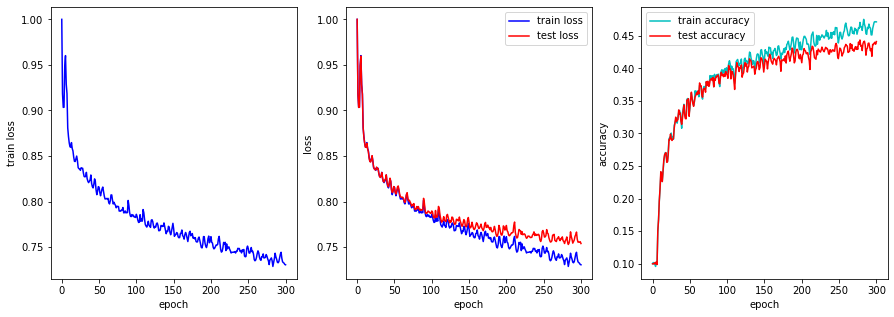

In [24]:
#display Train loss,train accuracy
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(loss_history2,'b')
ax[0].set_xlabel('epoch') 
ax[0].set_ylabel('train loss') 

ax[1].plot(loss_history2,'b')
ax[1].plot(test_losshistory2,'r')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')  
ax[1].legend(['train loss','test loss'])

ax[2].plot(train_acc_history2,'c')
ax[2].plot(val_acc_history2,'r')
ax[2].set_xlabel('epoch')
ax[2].set_ylabel('accuracy')  
ax[2].legend(['train accuracy','test accuracy']);

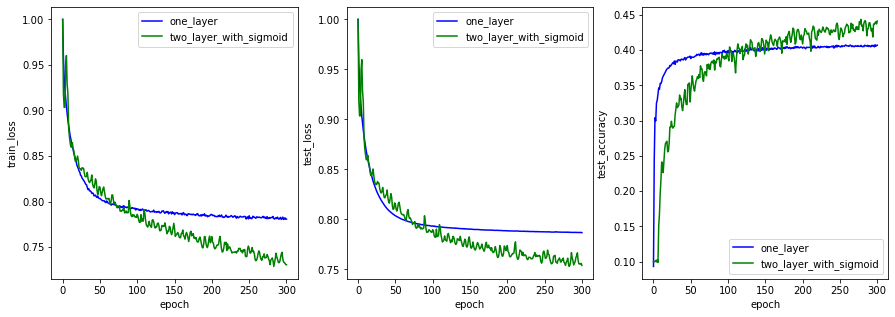

In [21]:
#comparision
#display Train loss,train accuracy
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(loss_history1,'b')
ax[0].plot(loss_history2,'g')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('train_loss')
ax[0].legend(['one_layer','two_layer_with_sigmoid']) 

ax[1].plot(test_losshistory1,'b')
ax[1].plot(test_losshistory2,'g')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('test_loss')
ax[1].legend(['one_layer','two_layer_with_sigmoid'])

ax[2].plot(val_acc_history1,'b')
ax[2].plot(val_acc_history2,'g')
ax[2].set_xlabel('epoch')
ax[2].set_ylabel('test_accuracy')
ax[2].legend(['one_layer','two_layer_with_sigmoid']);